### Detecting volumetric DDoS attack
Author: Jason Ng

The dataset used in this analysis is the CICIDS2017 dataset from Canadian Institute for Cybersecurity. The team generated benign network traffic using a profile system that abstracts behavior of human interactions and attack traffic generated from DDoS tools such as Hulk, GoldenEye and Low Orbit Ion Cannon (LOIC) - https://www.unb.ca/cic/datasets/ids-2017.html.

In [1]:
import pandas as pd
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
SEED = 123

In [2]:
# Load the data and perform cleaning
datapath = "/home/darklord/Downloads/CIC-IDS-2017/"
filelist = glob.glob(datapath+"MachineLearningCVE/*")
traffic_df = pd.concat(pd.read_csv(filename) for filename in filelist).reset_index(drop=True)
pd.set_option('mode.use_inf_as_na', True) # convert inf to nan
traffic_df.columns = traffic_df.columns.str.strip()
traffic_df.columns = traffic_df.columns.str.replace(" ", "_")
traffic_df['Flow_Bytes/s']=traffic_df['Flow_Bytes/s'].astype('float64')
traffic_df['Flow_Packets/s']=traffic_df['Flow_Packets/s'].astype('float64')
traffic_df['Flow_Bytes/s'].fillna(traffic_df['Flow_Bytes/s'].mean(),inplace=True)
traffic_df['Flow_Packets/s'].fillna(traffic_df['Flow_Packets/s'].mean(),inplace=True)    

/home/darklord/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.
/home/darklord/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


In [3]:
print("There are a total of {} flows in the dataset".format(len(traffic_df)))
traffic_df.head()

There are a total of 2830743 flows in the dataset


,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


There are 78 features that are provided by the flow generator that was used to produce the dataset. 
The schema of the dataset can be found here - http://netflowmeter.ca/netflowmeter.html

In [4]:
# Visualise labels
print(traffic_df.Label.value_counts())

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64


As seen in the label distribution, benign flows contribute to a large percentage of the dataset. This introduces the class imbalance problem, which we will show how we can address by using class weights in our model and down-sampling of the Benign class.

The is a multi-class classification problem, but before we can apply the model, we need to first convert the class label into numbers. We will also remove the web attacks and heartbleed attacks as we are specifically only interested in evaluating DDoS detection.

In [5]:
# Remove attack types that are non-DDoS
categories_to_remove = ["Web Attack � Brute Force",
                        "Web Attack � XSS",
                        "Infiltration",
                        "Web Attack � Sql Injection",
                        "Heartbleed"]
traffic_df = traffic_df[~traffic_df.isin(categories_to_remove)]

# Clean up data without any labels
traffic_df = traffic_df[~traffic_df.Label.isna()]
# Sanity check if anymore missing values
print(traffic_df.isnull().values.any())

# Create labels
LE = LabelEncoder()
traffic_df['code'] = LE.fit_transform(traffic_df.Label)
print("The classes are: {}".format(LE.classes_))
traffic_df.drop(['Label'], axis=1, inplace=True)

False
The classes are: ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'PortScan' 'SSH-Patator']


We will use the Random Forest algorithm for classifying the type of attacks. Since Random Forest uses bootstrap, we will not be using validation set and will split the dataset into training and test set. We will fix the number of trees and tune the max_feature parameters. Increasing the number of trees will not increase the variance hence we will just set a large number of trees once we found the optimal for max_features.

In [6]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(traffic_df.iloc[:,0:-1], traffic_df['code'], test_size=0.3, random_state=SEED)

In [7]:
# Initialise Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=40,
                       oob_score=True,
                       class_weight="balanced",
                       n_jobs=-1,
                       random_state=SEED)

# Perform Grid search for the optimal params
error_rate = []
min_features = 1
max_features = 78
starttime = time.time()
for i in np.linspace(min_features, max_features, 8, dtype=int):
    print("Running with {} max_features".format(i))
    rf_clf.set_params(max_features=i)
    rf_clf.fit(x_train, y_train)
    oob_error = 1 - rf_clf.oob_score_
    error_rate.append(oob_error)
endtime = time.time()
print("Classfier trained in {} minutes".format(int(endtime-starttime//60)))

Classfier trained in 1539505200 minutes


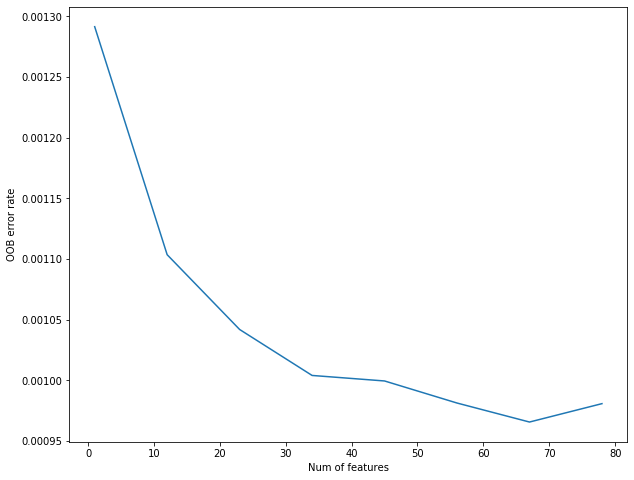

In [8]:
# Visualise the Out-of-Bag (OOB) Error
plt.figure(figsize=(10,8))
plt.plot(np.linspace(min_features, max_features, 8, dtype=int), error_rate)
plt.xlabel("Num of features")
plt.ylabel("OOB error rate")
plt.show()

From the OOB errors, we can observe that the lowest OOB occurs where number of features is around 55. Let's run Random Forest again, this time with the optimal parameters.

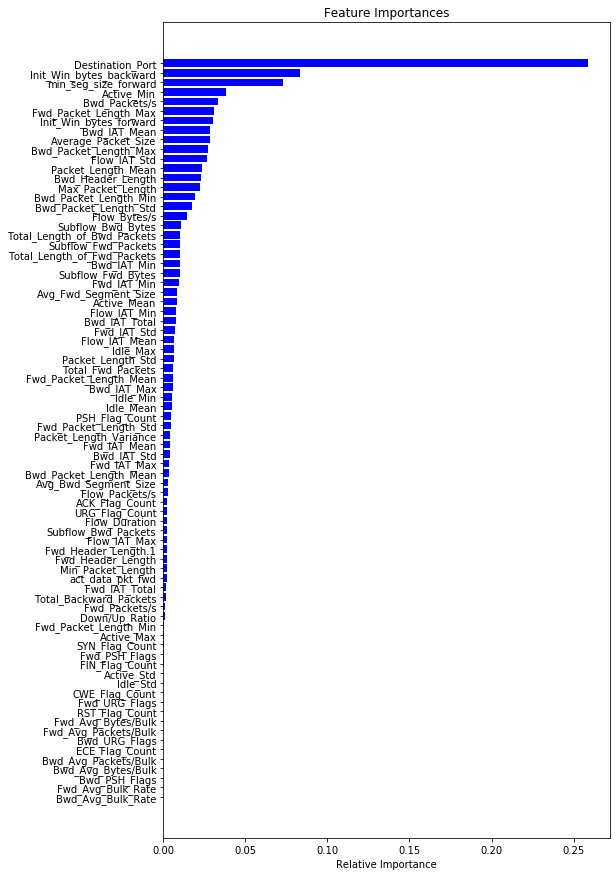

In [9]:
# Run with best params
rf_clf = RandomForestClassifier(n_estimators=80,
                                oob_score=True,
                                max_features=55,
                                class_weight="balanced",
                                random_state=SEED)
rf_clf.fit(x_train, y_train)

# Plot feature importance
features = traffic_df.columns[0:-1]
importances = rf_clf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    681814
             Bot       0.90      0.81      0.86       614
            DDoS       1.00      1.00      1.00     38496
   DoS GoldenEye       1.00      0.99      1.00      3047
        DoS Hulk       1.00      1.00      1.00     69538
DoS Slowhttptest       0.99      0.99      0.99      1650
   DoS slowloris       0.99      0.99      0.99      1795
     FTP-Patator       1.00      1.00      1.00      2390
        PortScan       0.99      1.00      1.00     47455
     SSH-Patator       1.00      1.00      1.00      1756

        accuracy                           1.00    848555
       macro avg       0.99      0.98      0.98    848555
    weighted avg       1.00      1.00      1.00    848555



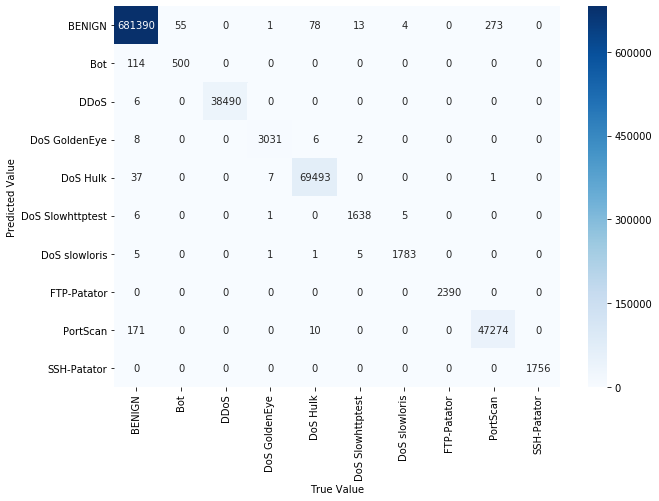

In [10]:
# Predict using test data
y_predict = rf_clf.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index = LE.classes_,
              columns = LE.classes_)

# Visualise the confusion matrix
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

# Classification report
print(classification_report(y_test, y_predict, target_names=LE.classes_))